Contour plot of ln(evidence) for loss against number of layers\
for limited and not limited thickness\
look at how dq can be in some areas assumed to be about 5% and dR is measured

ploting ln(evidence) for changes in $Dq/q$ vs $\lambda$, with $\lambda$ scaleing dR

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel
from sepObjective import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from CFitter2 import CFitter
import make_sim_data as msd
print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))


refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4
refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


In [2]:
def aPlotter(res, interestingNo, spacesize, figI):
    print(figI)
    # no = -1000
    # slc = slice(no-1000,no)
    useAbleLow=0.1
    useAbleHigh=10.
    xall=np.linspace(0,spacesize,len(res["logz"]))
    print("len",len(res["logz"]), "space size", spacesize)
    useable=np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if np.exp(y)>useAbleLow and np.exp(y)<=useAbleHigh]))
    # print(len(res["logz"]),res["logz"][slc])#summary()
    interesting = np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if x>=float(interestingNo)]))#.reshape((2,-2))
    print("len 2", len(interesting[0]), len(interesting), interesting[0,:3])
    print("logz max: ",max(res["logz"]),",min: ",min(res["logz"]))
    print("z max: ",max(np.exp(res["logz"])),",min: ",min(np.exp(res["logz"])))
#     print(res["logz"][:5],interesting[1,:5],useable[1,:5])
    # print("interesting")
#     xall=np.linspace(0,spacesize,len(res["logz"]))
#     xusable=np.linspace(0,spacesize,len(useable))
    plt.figure(figI)
    figI+=1
    plt.plot(xall,res["logz"])
    plt.title("ln(evidence) log scaled vs -ln(X)")
    # plt.yscale("log")
    plt.figure(figI)
    figI+=1
    plt.plot(interesting[0],interesting[1])
    plt.title(r"interesting values ln(evidence)  vs -ln(X) $\geq %d$" % interestingNo)
    if len(useable)>=2:
        plt.figure(figI)
        figI+=1
        plt.plot(useable[0],useable[1])
        plt.title(r"usful values ln(%.3f<evidence $\leq$ %.3f)  vs -ln(X)"%(useAbleLow,useAbleHigh))
    print(figI)
    return figI

In [3]:
figI = 0
# simple structure
thicks_true = [10,120,100,130,10]
bs_true = [0,5,4.5,5,10]
roughs_true = [0,0,0,0,0]
# bs = [5,4.5,5]
# thicks = [120,100,130]
# roughs = [0,0,0]
bs = bs_true
thicks = thicks_true
roughs = roughs_true
loss = 1.
no_layers = len(bs)
no_layers = len(bs_true)
# no_layers = 3
layers = []
names = []
#names = ['layer1','layer2']
for i in range(no_layers):
    names.append('layer'+str(i))
for i in range(no_layers):
        sld = SLD(bs[i],name=names[i])
        layers.append(sld(thicks[i],roughs[i]))
realStructure = layers[0]
for layer in layers[1:]:
    realStructure|=layer
print("done")

done


done


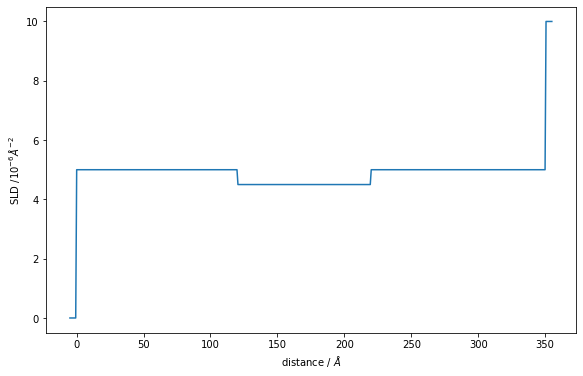

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]
#notebook
plt.figure(figI)
figI+=1
plt.plot(*realStructure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
print("done")

In [5]:
maxLength = 350
def logp_extra(model, data=None):
    returns = 0
    if sum(model.structure.slabs()[1:-1,0])>maxLength:
        returns = -np.inf
    return returns

In [6]:
q = np.linspace(0.005, 0.3, 70)
resolutions = [5.]
dRScaleBys = [5,10,15,20]
# lnPosts = []
# lnPostss = []
lnEvidence1 = []
lnEvidence2 = []
figI=1
# resolution = 5.
for dRScaleBy in dRScaleBys:
#     datas=[]
    for resolution in resolutions:
        print("dRScaleBy:",dRScaleBy,"resolution:",resolution)
        realModel = ReflectModel(realStructure, bkg=3e-6, dq=resolution)
        R = realModel(q, x_err=resolution)
        sim_dR = msd.main(sim_q=q,sim_R=R)*dRScaleBy
        data = Data1D(data= (q,R,sim_dR))
        
        objective = gO(data, 3, logpExtra=logp_extra)
        fitter = CFitter(objective)
        DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim()) #1:01:10 or 28:46 time
        DNSampler.run_nested(dlogz_init=0.05)# was 0.01
        result = DNSampler.results
        lnEvidence = result["logz"][-1]
        print("thickness limited lnEvidence:",lnEvidence)
        lnEvidence1.append(lnEvidence)

        objective = gO(data, 3)
        fitter = CFitter(objective)
        DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim()) #1:01:10 or 28:46 time
        DNSampler.run_nested(dlogz_init=0.05)# was 0.01
        result = DNSampler.results
        lnEvidence = result["logz"][-1]
        print("lnEvidence:",lnEvidence)
        lnEvidence2.append(lnEvidence)
#         print(lnPost)
#         lnPosts.append(lnPost)

dRScaleBy: 5 resolution: 5.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


24722it [09:52, 41.75it/s, batch: 7 | bound: 176 | nc: 13 | ncall: 162778 | eff(%): 15.188 | loglstar: 149.209 < 156.740 < 155.737 | logz: 135.168 +/-    nan | stop:  0.997]            


thickness limited lnEvidence: 135.1592527109629


33815it [10:23, 54.20it/s, batch: 9 | bound: 191 | nc: 2 | ncall: 170266 | eff(%): 19.860 | loglstar: 148.140 < 156.688 < 155.581 | logz: 135.506 +/-  0.259 | stop:  0.887]            


lnEvidence: 135.51363092823152
dRScaleBy: 10 resolution: 5.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


30497it [12:58, 39.16it/s, batch: 8 | bound: 214 | nc: 5 | ncall: 258143 | eff(%): 11.814 | loglstar: 99.817 < 108.357 < 108.293 | logz: 90.569 +/-    nan | stop:  0.898]             


thickness limited lnEvidence: 90.58261765110471


24816it [08:05, 51.14it/s, batch: 8 | bound: 144 | nc: 2 | ncall: 136429 | eff(%): 18.190 | loglstar: 100.046 < 108.184 < 106.905 | logz: 91.408 +/-  0.225 | stop:  0.902]           


lnEvidence: 91.41095740682941
dRScaleBy: 15 resolution: 5.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


22267it [08:05, 45.82it/s, batch: 7 | bound: 159 | nc: 4 | ncall: 145549 | eff(%): 15.299 | loglstar: 71.747 < 79.866 < 78.818 | logz: 64.748 +/-    nan | stop:  0.959]              


thickness limited lnEvidence: 64.74633814145514


21295it [07:50, 45.28it/s, batch: 7 | bound: 134 | nc: 34 | ncall: 142133 | eff(%): 14.982 | loglstar: 71.713 < 79.552 < 77.982 | logz: 65.277 +/-  0.205 | stop:  0.942]             


lnEvidence: 65.24183708526485
dRScaleBy: 20 resolution: 5.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


23457it [10:00, 39.03it/s, batch: 8 | bound: 166 | nc: 7 | ncall: 182211 | eff(%): 12.874 | loglstar: 51.256 < 59.703 < 58.369 | logz: 46.202 +/-    nan | stop:  0.876]              


thickness limited lnEvidence: 46.21292687457111


28075it [11:31, 40.61it/s, batch: 8 | bound: 231 | nc: 1 | ncall: 225877 | eff(%): 12.429 | loglstar: 50.680 < 59.841 < 59.771 | logz: 47.229 +/-  0.185 | stop:  0.907]           


lnEvidence: 47.215058461896525


In [7]:
f=open("dDqDR2Dupdated2.txt","w+")
f.write("limited max thickness ln(evidence):\n")
for lnEvidence in lnEvidence1:
    f.write(str(lnEvidence)+"\n")
f.write("\nnot limited max thickness ln(evidence):\n")
for lnEvidence in lnEvidence2:
    f.write(str(lnEvidence)+"\n")
f.close()

26499it [24:55, 17.72it/s, batch: 7 | bound: 706 | nc: 8 | ncall: 646207 | eff(%):  4.101 | loglstar: -202.191 < -195.105 < -197.037 | logz: -220.134 +/-  0.292 | stop:  0.952]         
-220.11328681456592

28379it [08:30, 55.62it/s, batch: 8 | bound: 181 | nc: 6 | ncall: 161880 | eff(%): 17.531 | loglstar: 1000.415 < 1008.232 < 1007.220 | logz: 982.787 +/-  0.292 | stop:  0.987]          
982.7887810159078

32388it [24:41, 21.86it/s, batch: 8 | bound: 716 | nc: 6 | ncall: 590509 | eff(%):  5.485 | loglstar: 1075.286 < 1083.785 < 1081.905 | logz: 1055.241 +/-  0.310 | stop:  0.996]         
1055.2684365805314

30559it [4:44:11,  1.79it/s, batch: 7 | bound: 9951 | nc: 9 | ncall: 7637451 | eff(%):  0.400 | loglstar: -123.375 < -115.445 < -116.614 | logz: -146.484 +/-  0.325 | stop:  0.954]            
-146.47705209627895

30163it [13:24, 37.49it/s, batch: 8 | bound: 316 | nc: 3 | ncall: 287583 | eff(%): 10.488 | loglstar: -202.911 < -195.011 < -196.521 | logz: -220.609 +/-  0.294 | stop:  0.896]         
-220.60610280345477

28286it [08:12, 57.44it/s, batch: 8 | bound: 173 | nc: 3 | ncall: 156091 | eff(%): 18.121 | loglstar: 1000.488 < 1008.240 < 1007.316 | logz: 982.981 +/-  0.291 | stop:  0.962]          
982.9960603373407

28828it [11:10, 42.98it/s, batch: 7 | bound: 262 | nc: 13 | ncall: 232396 | eff(%): 12.405 | loglstar: 1075.951 < 1083.723 < 1081.587 | logz: 1055.021 +/-  0.312 | stop:  0.982]         
1055.0312970246378

27767it [30:19, 15.26it/s, batch: 6 | bound: 879 | nc: 7 | ncall: 707327 | eff(%):  3.926 | loglstar: -122.960 < -115.814 < -118.256 | logz: -146.916 +/-  0.329 | stop:  0.958]          
-146.91675261007052

29402it [08:33, 57.22it/s, batch: 8 | bound: 177 | nc: 4 | ncall: 157628 | eff(%): 18.653 | loglstar: -202.548 < -195.020 < -196.058 | logz: -220.605 +/-  0.294 | stop:  0.979]         
-220.6032067872486

30570it [08:33, 59.56it/s, batch: 8 | bound: 171 | nc: 2 | ncall: 151998 | eff(%): 20.112 | loglstar: 1000.298 < 1008.302 < 1007.287 | logz: 982.565 +/-  0.294 | stop:  0.917]          
982.54792841728

31217it [10:50, 48.03it/s, batch: 8 | bound: 245 | nc: 2 | ncall: 221857 | eff(%): 14.071 | loglstar: 1075.649 < 1083.508 < 1081.140 | logz: 1054.841 +/-  0.312 | stop:  0.874]         
1054.832846010915

31648it [3:08:55,  2.79it/s, batch: 8 | bound: 7087 | nc: 4 | ncall: 5426582 | eff(%):  0.583 | loglstar: -123.704 < -115.501 < -117.517 | logz: -146.624 +/-  0.325 | stop:  0.911]            
-146.635041601231

27858it [13:01, 35.64it/s, batch: 8 | bound: 313 | nc: 2 | ncall: 286177 | eff(%):  9.735 | loglstar: -202.557 < -195.077 < -195.935 | logz: -220.541 +/-  0.294 | stop:  0.950]         
-220.51950736917618

29685it [08:45, 56.49it/s, batch: 8 | bound: 186 | nc: 1 | ncall: 167036 | eff(%): 17.772 | loglstar: 1000.284 < 1008.179 < 1006.634 | logz: 982.917 +/-  0.291 | stop:  0.947]
982.9139570644866

32599it [08:38, 62.89it/s, batch: 8 | bound: 175 | nc: 11 | ncall: 153989 | eff(%): 21.170 | loglstar: 1075.323 < 1083.736 < 1081.824 | logz: 1054.970 +/-  0.311 | stop:  0.858]
1054.9575362870723

33744it [2:08:35,  4.37it/s, batch: 8 | bound: 4335 | nc: 1 | ncall: 3416253 | eff(%):  0.988 | loglstar: -123.740 < -115.761 < -117.602 | logz: -147.612 +/-  0.332 | stop:  0.821]
-147.6220194411551

17

-220.11328681456592, 982.7887810159078, 1055.2684365805314, -146.47705209627895, -220.60610280345477, 982.9960603373407, 1055.0312970246378, -146.91675261007052, -220.6032067872486, 982.54792841728, 1054.832846010915, -146.635041601231, -220.51950736917618, 982.9139570644866, 1054.9575362870723, -147.6220194411551

In [19]:
def toArray(line,n,m=-1):
    array=line.reshape((n,m))
    return array

def meshGraph(line, xs, ys, xlabel="", ylabel="", title="",printType="", figI=0):
    #resolutions = [1.,3.,7.,9.]
    #dRScaleBys = [5,10,15,20]
    ha_s = ["left", "center", "center","center", "right"]

    print(printType,line)#"not thickness limited ln(post):",line)
    n, m = len(xs), len(ys)
    zs = toArray(line,m,n)
#     zs= np.array(lnPosts1).reshape(len(xs), len(ys))
    plt.figure(figI)
    figI+=1
    plt.contour(xs,ys,zs,alpha=0.5);
    plt.contourf(xs,ys,zs,alpha=0.3);
    plt.colorbar();
    for i in range(len(xs)):
        for j in range(len(ys)):
            plt.scatter(xs[i],ys[j],c="red",marker="x");
            ha = ha_s[i]
            plt.annotate("%.3f"%zs[j][i],(xs[i],ys[j]),
                        horizontalalignment=ha, fontsize="small", verticalalignment='bottom')
    # for x in dRScaleBys:
    #     for y in resolutions:
    #         plt.scatter(x,y,c="red",marker="x");
    plt.ylabel(ylabel);#"dq");
    plt.xlabel(xlabel);#"dR scaled by");
    plt.title(title);#"thickness limited contour plot of ln(evidence) for dq vs dR scaled by");
    plt.tight_layout();
    plt.show();
    return figI

thickness limited ln(post):  [135.15925271  90.58261765  64.74633814  46.21292687]


TypeError: Input z must be at least a 2x2 array.

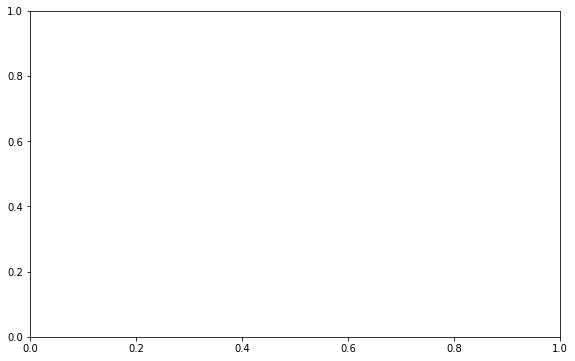

In [9]:
xs=resolutions
ys=dRScaleBys
ylabel="dRScaleBys"
xlabel="resolutions"
title="thickness limited contour plot of ln(evidence) for resolutions vs dRScaleBys"
line = np.array(lnEvidence1)
figI=meshGraph(line, xs, ys, xlabel, ylabel, title,"thickness limited ln(post): ", figI)



not thickness limited ln(post):  [135.51363093  91.41095741  65.24183709  47.21505846]


TypeError: Input z must be at least a 2x2 array.

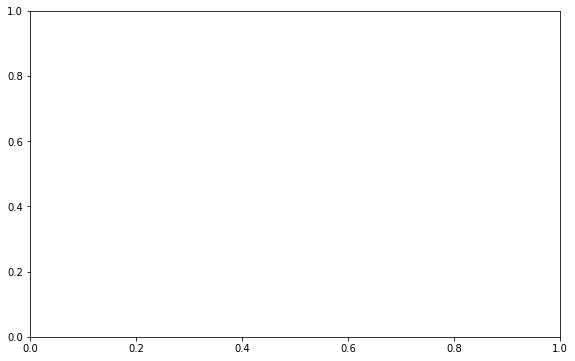

In [10]:

title="not thickness limited contour plot of ln(evidence) for resolutions vs dRScaleBys"
line = np.array(lnEvidence2)
figI=meshGraph(line, xs, ys, xlabel, ylabel, title, "not thickness limited ln(post): ", figI)

thickness limited ln(post):  [-886.49323833 -257.20965902  135.15925271  -60.63565658 -681.09122983
 -172.92482399  -10.11082523   90.58261765   40.71526017 -114.35333093
  -58.2528621    17.72308248   64.74633814   42.35228568  -26.0655558
  -27.5177435    17.92008799   46.21292687   34.42642568   -4.13848451]


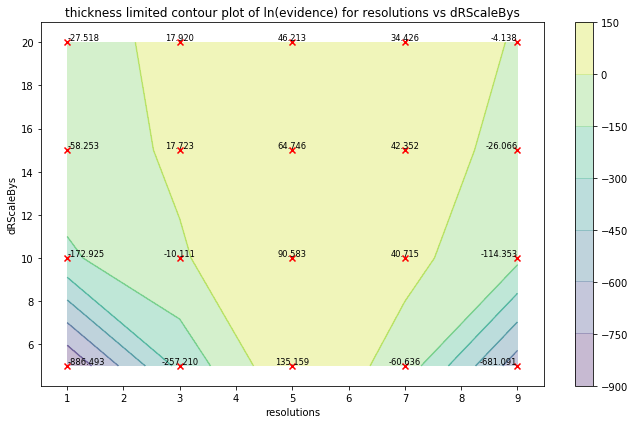

not thickness limited ln(post):  [-885.9481422  -256.91732197  135.51363093  -61.15745297 -681.43741786
 -173.10177084  -10.58265352   91.41095741   41.01100048 -114.47440076
  -58.69327271   17.53297187   65.24183709   42.47082191  -26.07282113
  -27.81706054   17.91245804   47.21505846   34.32935903   -4.30802045]


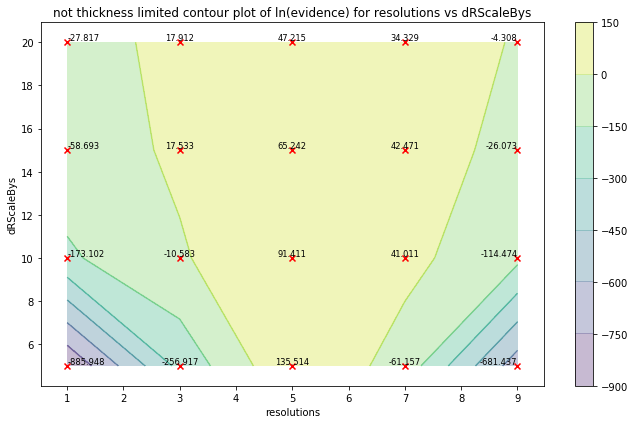

In [20]:
xs=[1.,3., 5.,7.,9.]
ys= [5,10,15,20]
ylabel="dRScaleBys"
xlabel="resolutions"
title="thickness limited contour plot of ln(evidence) for resolutions vs dRScaleBys"
previous = [-886.49323833, -257.20965902,  -60.63565658, -681.09122983, -172.92482399
  -10.11082523,   40.71526017, -114.35333093,  -58.2528621,    17.72308248,
   42.35228568,  -26.0655558,   -27.5177435,    17.92008799,   34.42642568,
   -4.13848451]
line = np.array(lnEvidence1)
combined = np.array([-886.49323833, -257.20965902, lnEvidence1[0],-60.63565658, -681.09122983,
                     -172.92482399, -10.11082523, lnEvidence1[1],40.71526017, -114.35333093,
                     -58.2528621,    17.72308248, lnEvidence1[2], 42.35228568,  -26.0655558,
                     -27.5177435,    17.92008799, lnEvidence1[3],  34.42642568, -4.13848451])
figI=meshGraph(combined, xs, ys, xlabel, ylabel, title,"thickness limited ln(post): ", figI)


title="not thickness limited contour plot of ln(evidence) for resolutions vs dRScaleBys"
previous = [-885.9481422,  -256.91732197,  -61.15745297, -681.43741786, -173.10177084,
  -10.58265352,   41.01100048, -114.47440076,  -58.69327271,   17.53297187,
   42.47082191,  -26.07282113,  -27.81706054,   17.91245804,   34.32935903,
     -4.30802045]
line = np.array(lnEvidence2)
combined = np.array([-885.9481422,  -256.91732197, lnEvidence2[0] , -61.15745297, -681.43741786,
                     -173.10177084, -10.58265352, lnEvidence2[1] ,  41.01100048, -114.47440076,
                     -58.69327271,   17.53297187, lnEvidence2[2], 42.47082191,  -26.07282113,
                     -27.81706054,   17.91245804, lnEvidence2[3],  34.32935903, -4.30802045])
figI=meshGraph(combined, xs, ys, xlabel, ylabel, title, "not thickness limited ln(post): ", figI)

thickness limited ln(Evidence): [-886.2338759719516, -256.8224918348395, -61.03303894872692, -682.6266779760213, -173.0746737843894, -10.302971524391873, 40.878851270732426, -114.4072512583621, -58.64780510695973, 17.468412975171937, 42.341773042336406, -26.07731100106868, -27.701438332130166, 17.923427521647163, 34.37910322948846, -4.680316380923956]
not thickness limited ln(Evidence): [-886.3654858783067, -256.92328393233277, -61.02068196011918, -681.4610409074794, -173.05969495127744, -10.485837192186086, 40.75223150230152, -114.68229572753494, -58.44818983219997, 17.37091701476931, 42.5108219989175, -26.765799975725457, -27.847024452945774, 17.7413881949897, 34.524598968004895, -4.491294767664335]

In [ ]:
# for objective1,objective2 in zip(objectives1,objectives2):
#     plt.figure(figI)
#     figI+=1

#     plt.subplot(2,2,1).set_title("data plotted for limited max thickness")
#     fig, ax = objective1.plot()
#     plt.subplot(2,2,2).set_title("structure plotted for limited max thickness")
#     plt.plot(*objective1.model.structure.sld_profile())
#     plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
#     plt.xlabel('distance / $\AA$');

#     plt.subplot(2,2,3).set_title("data plotted for limited max thickness")
#     fig, ax = objective2.plot()
#     plt.subplot(2,2,4).set_title("structure plotted for limited max thickness")
#     plt.plot(*objective2.model.structure.sld_profile())
#     plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
#     plt.xlabel('distance / $\AA$');
